# CONSTRUCT STRATEGIES AND BACKTESTING WITH MACHINE LEARNING

### IMPORT DATASET AND MISSING VALUE HANDLING

In [1]:
!pip install -q ta backtesting hyperopt

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import json

from hyperopt import hp, tpe, fmin, pyll, Trials, STATUS_OK
from hyperopt.fmin import generate_trials_to_calculate
from functools import partial

import ta
from backtesting import Backtest, Strategy

import matplotlib.pyplot as plt
import matplotlib.dates as md
%matplotlib inline
import seaborn as sns
sns.set()

import traceback
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

C:\Users\phath\anaconda3\Lib\site-packages\backtesting\_plotting.py:53: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [24]:
import yfinance as yf 
df_full = yf.download("NFLX",start="2015-1-1", end="2025-1-1")
df_full.reset_index()
df_full

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,49.151428,50.331429,48.731430,49.848572,49.848572,13475000
2015-01-05,49.258572,49.258572,47.147144,47.311428,47.311428,18165000
2015-01-06,47.347141,47.639999,45.661430,46.501431,46.501431,16037700
2015-01-07,47.347141,47.421429,46.271427,46.742859,46.742859,9849700
2015-01-08,47.119999,47.835712,46.478573,47.779999,47.779999,9601900
...,...,...,...,...,...,...
2024-12-24,915.000000,935.849976,911.700012,932.119995,932.119995,2320300
2024-12-26,928.400024,930.489990,915.299988,924.140015,924.140015,2340300
2024-12-27,916.010010,918.130005,894.500000,907.549988,907.549988,3226200


## 2. CONSTRUCT STRATEGY

### 2.1. DATA VISUALIZATION

In [27]:
fig = plt.figure(figsize=(11, 4))
plt.plot(df_full['Close'])

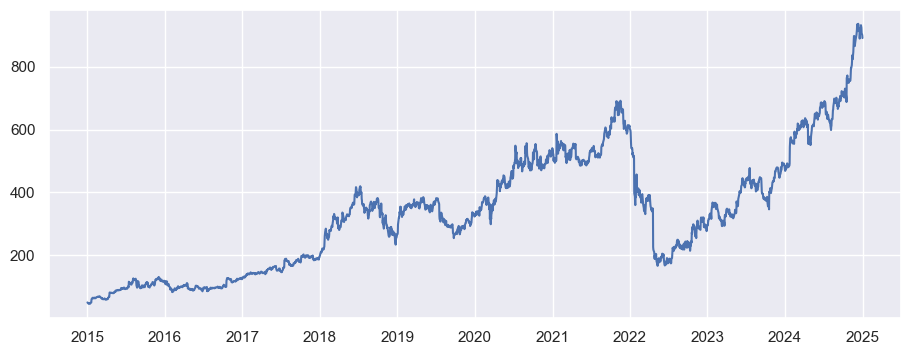

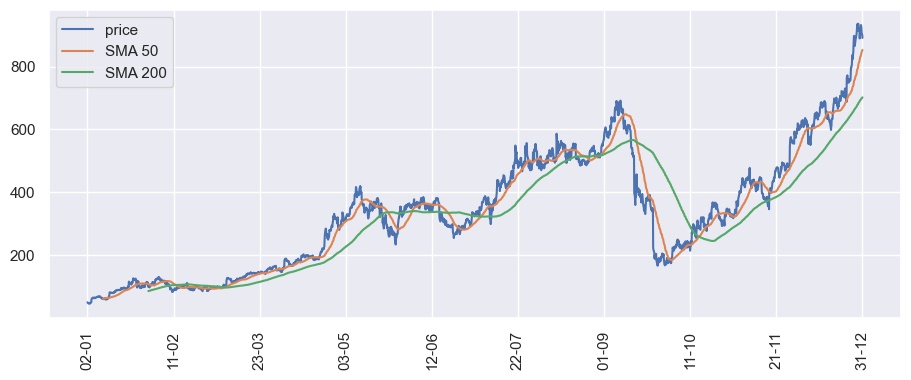

In [28]:
df = df_full
df['SMA_50'] = ta.trend.SMAIndicator(close=df['Close'], window=50).sma_indicator()
df['SMA_200'] = ta.trend.SMAIndicator(close=df['Close'], window=200).sma_indicator()

fig = plt.figure(figsize=(11, 4))
dates = df['Close'].index
plt.plot(df['Close'], label='price')
plt.plot(df['SMA_50'], label='SMA 50')
plt.plot(df['SMA_200'], label='SMA 200')

#Display x axis
ax = plt.gca()
xfmt = md.DateFormatter('%d-%m')
t = pd.date_range(start=min(dates),
                  end=max(dates), periods=10)
ax.set_xticks(t)
plt.xticks(rotation=90)
ax.xaxis.set_major_formatter(xfmt)

plt.legend()
plt.show()

### 2.2. FIND THE SIGN OF TRADING

In [29]:
position = pd.Series(index=df.index)
buy = df[(df['SMA_50'] > df['SMA_200']) & (df['SMA_50'].shift(1) <= df['SMA_200'].shift(1))]
sell = df[(df['SMA_50'] < df['SMA_200']) & (df['SMA_50'].shift(1) >= df['SMA_200'].shift(1))]
position.loc[buy.index] = 1
position.loc[sell.index] = -1
position = position.dropna()
df['position'] = position.dropna()

In [30]:
df.dropna()

,Open,High,Low,Close,Adj Close,Volume,SMA_50,SMA_200,position
Date,,,,,,,,,
2016-02-23,91.400002,92.489998,89.050003,89.120003,89.120003,12744400,104.170000,104.840686,-1.0
2016-10-10,103.180000,104.529999,102.760002,103.330002,103.330002,6699700,97.404200,97.271350,1.0
2018-11-19,283.790009,285.089996,269.149994,270.600006,270.600006,12993800,335.616600,336.248850,-1.0
2019-03-13,355.809998,362.480011,352.769989,361.209991,361.209991,6444100,341.342401,339.958000,1.0
2019-08-28,289.470001,292.820007,287.750000,291.769989,291.769989,3955700,334.486198,334.556899,-1.0
2020-01-30,341.100006,348.200012,339.250000,347.739990,347.739990,5328100,323.364200,322.519699,1.0
2021-06-03,495.190002,496.660004,487.250000,489.429993,489.429993,3887400,513.972596,514.504499,-1.0
2021-08-16,515.239990,523.380005,512.299988,517.919983,517.919983,2032800,517.477800,517.182449,1.0
2022-02-03,421.440002,429.260010,404.279999,405.600006,405.600006,9905200,554.393201,558.634198,-1.0


## 2. BACKTESTING

### 2.1. BACKTESTING OVERVIEW

In [68]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA


class SmaCross(Strategy):
    def init(self):
        price = self.data.Close
        self.ma1 = self.I(SMA, price, 50)
        self.ma2 = self.I(SMA, price, 200)

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.sell()


bt = Backtest(df, SmaCross, commission=.002,
              exclusive_orders=True)
stats = bt.run()
bt.plot()

GridPlot(id='p2453', ...)

### 2.2. BACKTESTING HANDLING

In [31]:
cash = 100000000
commission = 0.001
max_evals = 100
strat = 'SMA'
fitness = 'return'

In [32]:
class GeneralStrategy(Strategy):
    def init(self):
        pass

    def next(self):
        if self.data.position == 1:
            self.buy()
        elif self.data.position == -1:
            self.position.close()

In [34]:
bt = Backtest(df,
            GeneralStrategy,
            cash=cash,
            commission=commission,
            trade_on_close=True,
            exclusive_orders=True)

stats = bt.run()
stats.to_frame()

,0
Start,2015-01-02 00:00:00
End,2024-12-31 00:00:00
Duration,3651 days 00:00:00
Exposure Time [%],44.117647
Equity Final [$],6785704.33525
Equity Peak [$],7130116.380904
Commissions [$],17809.694824
Return [%],578.570434
Buy & Hold Return [%],1688.055255
Return (Ann.) [%],21.141153


In [35]:
def bh_strat(df):
    return round(100*(df['Close'][-1] - df['Close'][0]) / df['Close'][0], 2)

In [36]:
bh_strat(df)

1688.06

In [40]:
def find_position(df, paras, strat):
    if strat == 'SMA':
        try:
            ma_short = int(paras['ma_short'])
            ma_long = int(paras['ma_long'])
        except:
            ma_short = int(paras[0])
            ma_long = int(paras[1])

        ma_s = ta.trend.SMAIndicator(close=df['Close'], window=ma_short).sma_indicator()
        ma_l = ta.trend.SMAIndicator(close=df['Close'], window=ma_long).sma_indicator()

        position = pd.Series(index=df.index)
        buy = df[(ma_s > ma_l) & (ma_s.shift(1) <= ma_l.shift(1))]
        sell = df[(ma_s < ma_l) & (ma_s.shift(1) >= ma_l.shift(1))]
        position.loc[buy.index] = 1
        position.loc[sell.index] = -1
        position = position.dropna()

    return position

In [41]:
def compute_sharpe(returns, window=252):
    try:
        return np.sqrt(window) * (returns.mean() / returns.std())
    except:
        return np.nan

In [42]:
def backtest(df, cash, commission, print_result=True):
    bt = Backtest(df,
                  GeneralStrategy,
                  cash=cash,
                  commission=commission,
                  trade_on_close=True,
                  exclusive_orders=True)

    stats = bt.run()
    stats = stats.to_frame()
    # # re-compute stats
    stats.loc['Duration'] = len(df)
    returns = stats.loc['_equity_curve'][0]['Equity'].pct_change()*100
    stats.loc['Sharpe Ratio'] = compute_sharpe(returns=returns, window=len(df))
    stats = stats.round(2)

    if print_result is True:
        print('Return: %.2f%%, Sharpe Ratio: %.2f' % (stats.loc['Return [%]'], stats.loc['Sharpe Ratio']))

    return bt, stats

In [43]:
def score(paras, df, cash, commission, strat, fitness, print_result=False):
    position = find_position(df, paras, strat)
    df['position'] = position

    bt, stats = backtest(df, cash, commission, print_result=print_result)

    if fitness == 'sharpe':
        # optimize Sharpe ratio
        res = -stats.loc['Sharpe Ratio'][0]
        if res == 'nan' or np.isnan(res):
            res = 0
    if fitness == 'return':
        # optimize gross return
        res = -stats.loc['Return [%]'][0]

    return res

In [46]:
df = df_full.copy()

In [47]:
fspace = {'ma_short': hp.quniform('ma_short', 25, 150, 5),
          'ma_long': hp.quniform('ma_long', 200, 400, 5)}

fmin_objective = partial(score, df=df, cash=cash, commission=commission, strat=strat, fitness=fitness)

paras_best = fmin(fn=fmin_objective, space=fspace, algo=tpe.suggest, max_evals=max_evals)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.77trial/s, best loss: -681.425084258844]


In [48]:
paras_default = {'ma_short': 50, 'ma_long': 200}

print('Default:')
print(paras_default)
score(paras_default, df, cash, commission, strat, fitness, print_result=True)

print('\nBest:')
print(paras_best)
score(paras_best, df, cash, commission, strat, fitness, print_result=True)

Default:
{'ma_short': 50, 'ma_long': 200}
Return: 578.57%, Sharpe Ratio: 2.41

Best:
{'ma_long': 340.0, 'ma_short': 105.0}
Return: 681.43%, Sharpe Ratio: 2.60


-681.425084258844

In [49]:
bt, stats = backtest(df, cash, commission)
bt.plot(plot_width = 900, plot_volume=False, superimpose=False)

Return: 681.43%, Sharpe Ratio: 2.60


GridPlot(id='p1618', ...)

In [50]:
df.dropna()

,Open,High,Low,Close,Adj Close,Volume,SMA_50,SMA_200,position
2016-06-15,94.610001,95.459999,93.500000,94.290001,94.290001,7675400,96.653400,103.376300,-1.0
2016-12-02,116.750000,120.980003,116.750000,120.809998,120.809998,8953600,113.613000,100.490100,1.0
2019-09-11,285.700012,292.649994,284.609985,288.269989,288.269989,7405900,320.924998,334.910449,-1.0
2020-03-16,306.630005,334.350006,294.750000,298.839996,298.839996,10559900,355.555000,322.914599,1.0
2022-03-18,372.000000,381.799988,368.470001,380.600006,380.600006,8324800,412.960601,540.502099,-1.0
2023-04-05,345.299988,345.429993,336.250000,342.350006,342.350006,4205500,333.213600,274.432601,1.0


In [51]:
def init_paras(strat):
    if strat == 'SMA':
        return {'ma_short': 20, 'ma_long': 50}

In [52]:
def split_data(df_split, seq):
    df_train = pd.concat([df_split[seq], df_split[seq+1]])
    df_test = df_split[seq+2]

    return df_train, df_test

def print_perf(period, fitness, loss):
    perf_df = pd.DataFrame()
    perf_df[f'{fitness}_{period}'] = [-round(loss, 2)]

    return perf_df

In [53]:
def bo_tuning(df, cash, commission, max_evals, strat, fitness, trials=None):
    if strat == 'SMA':
        fspace = {'ma_short': hp.quniform('ma_short', 5, 20, 5),
                'ma_long': hp.quniform('ma_long', 30, 50, 5)}

    fmin_objective = partial(score, df=df, cash=cash, commission=commission, strat=strat, fitness=fitness)

    if trials != None:
        paras_best = fmin(fn=fmin_objective, space=fspace, algo=tpe.suggest, max_evals=max_evals, trials=trials, show_progressbar=False)
    else:
        paras_best = fmin(fn=fmin_objective, space=fspace, algo=tpe.suggest, max_evals=max_evals, show_progressbar=False)

    return paras_best

In [54]:
from scipy.stats import ttest_1samp, wilcoxon

def mean_ttest(df, mean_val, col=None):
    # Perform t-test
    if col is None:
        statistic, pval = ttest_1samp(df, mean_val, alternative='greater')
    else:
        statistic, pval = ttest_1samp(df[col], mean_val, alternative='greater')

    # Determine if m1 is greater than m2 based on p-value
    m1_greater_m2 = pval < 0.05

    # Create results dictionary
    results = {
        "statistic": statistic,
        "pvalue": pval,
        "m1_greater_m2": m1_greater_m2,
    }

    return results

def compare_means_ttest(df1, df2, col1=None, col2=None):
    # Perform wilcoxon
    if col1 is None or col2 is None:
        statistic, pval = wilcoxon(df1, df2, alternative='greater')
    else:
        statistic, pval = wilcoxon(df1[col1], df2[col2], alternative='greater')

    # Determine if m1 is greater than m2 based on p-value
    m1_greater_m2 = pval < 0.05

    # Create results dictionary
    results = {
        "statistic": statistic,
        "pvalue": pval,
        "m1_greater_m2": m1_greater_m2,
    }

    return results

In [55]:
#  trials = generate_trials_to_calculate([paras_default])
#  bo_tuning(df, cash, commission, max_evals, strat, fitness, trials)

In [56]:
cash = 1000000
commission = 0.001
max_evals = 50
strat = 'SMA'
fitness = 'return'
num_split = 22

In [57]:
time_start = time.time()

perf_total_train = pd.DataFrame()
perf_total_test = pd.DataFrame()

df_stock = df_full.copy()
df_split = np.array_split(df_stock, num_split)
paras_default = init_paras(strat)

for seq in range(len(df_split)-2):
    df_train, df_test = split_data(df_split, seq)

    #training
    try:
        trials = generate_trials_to_calculate([paras_default])
        paras_train = bo_tuning(df_train, cash, commission, max_evals, strat, fitness, trials)
        loss_train = score(paras_train, df_train, cash, commission, strat, fitness)
    except:
        paras_train = paras_default
        loss_train = score(paras_train, df_train, cash, commission, strat, fitness)

    loss_train_default = score(paras_default, df_train, cash, commission, strat, fitness)

    print('[{}] train'.format(seq), df_train.index[0], paras_train, loss_train, loss_train_default)

    #testing
    paras_test = paras_train
    loss_test = score(paras_test, df_test, cash, commission, strat, fitness)

    loss_test_default = score(paras_default, df_test, cash, commission, strat, fitness)

    print('test', df_test.index[0], loss_test, loss_test_default)

    perf_train = print_perf('train', fitness, loss_train)
    perf_test = print_perf('test', fitness, loss_test)

    perf_train_default = print_perf('train_default', fitness, loss_train_default)
    perf_test_default = print_perf('test_default', fitness, loss_test_default)

    temp_total_train = pd.concat([perf_train, perf_train_default], axis=1)
    temp_total_test = pd.concat([perf_test, perf_test_default], axis=1)

    perf_total_train = pd.concat([perf_total_train, temp_total_train])
    perf_total_test = pd.concat([perf_total_test, temp_total_test])

print(len(df_train), len(df_test))
print(round(perf_total_train.mean(),2))
print(round(perf_total_test.mean(),2))

print('Running time: %.2fs -- %.2fm' % (time.time() - time_start, (time.time() - time_start)/60))

[0] train 2015-01-02 00:00:00 {'ma_long': 35.0, 'ma_short': 10.0} -73.22672354320754 -44.293707993045025
test 2015-12-01 00:00:00 9.434505086650082 10.223031312881469
[1] train 2015-06-18 00:00:00 {'ma_long': 45.0, 'ma_short': 20.0} -6.838880508110812 2.526617858270253
test 2016-05-17 00:00:00 -31.386134452062986 -31.386134452062986
[2] train 2015-12-01 00:00:00 {'ma_long': 45.0, 'ma_short': 20.0} -21.265986889080796 -19.072020192139455
test 2016-10-28 00:00:00 -0.0 -0.0
[3] train 2016-05-17 00:00:00 {'ma_long': 45.0, 'ma_short': 10.0} -51.9029117546112 -48.47439128189697
test 2017-04-17 00:00:00 8.123758212155138 3.580670284707646
[4] train 2016-10-28 00:00:00 {'ma_long': 30.0, 'ma_short': 20.0} -14.3820279786438 3.580670284707646
test 2017-09-28 00:00:00 -45.864724723327626 -53.46104060900877
[5] train 2017-04-17 00:00:00 {'ma_long': 50.0, 'ma_short': 5.0} -83.7424315177948 -48.961806014584354
test 2018-03-15 00:00:00 -0.0 -0.0
[6] train 2017-09-28 00:00:00 {'ma_long': 35.0, 'ma_shor

In [58]:
perf_total_train.reset_index(drop=True, inplace=True)
perf_total_train.index.names = ['Period']
perf_total_test.reset_index(drop=True, inplace=True)
perf_total_test.index.names = ['Period']
pd.concat([perf_total_train, perf_total_test], axis=1)

,return_train,return_train_default,return_test,return_test_default
Period,,,,
0,73.23,44.29,-9.43,-10.22
1,6.84,-2.53,31.39,31.39
2,21.27,19.07,0.00,0.00
3,51.90,48.47,-8.12,-3.58
4,14.38,-3.58,45.86,53.46
5,83.74,48.96,0.00,0.00
6,69.55,65.80,7.95,-2.61
7,18.14,-11.99,-17.19,-14.56
8,-3.68,-14.54,13.37,14.72


In [59]:
results_train = mean_ttest(perf_total_test, 0, 'return_test')
print('optimized_return', results_train)

results_test = mean_ttest(perf_total_test, 0, 'return_test_default')
print('default_return', results_test)

optimized_return {'statistic': 1.253908025387253, 'pvalue': 0.1125422238880608, 'm1_greater_m2': False}
default_return {'statistic': 1.3181418509135476, 'pvalue': 0.10156377920648646, 'm1_greater_m2': False}


In [60]:
results_train = compare_means_ttest(perf_total_train, perf_total_train, 'return_train', 'return_train_default')
print('train', results_train)

results_test = compare_means_ttest(perf_total_test, perf_total_test, 'return_test', 'return_test_default')
print('test', results_test)

train {'statistic': 210.0, 'pvalue': 9.5367431640625e-07, 'm1_greater_m2': True}
test {'statistic': 42.0, 'pvalue': 0.7451012575195681, 'm1_greater_m2': False}


In [61]:
df_stock = df_full.copy()
df_split = np.array_split(df_stock, num_split)
df_sam1, df_sam2 = split_data(df_split, 12)
paras_best = {'ma_long': 30.0, 'ma_short': 5.0}
score(paras_best, df_sam2, cash, commission, strat, fitness)

bt, stats = backtest(df_sam2, cash, commission)
bt.plot(plot_width = 900, plot_volume=False, superimpose=False)

Return: 21.80%, Sharpe Ratio: 1.84


GridPlot(id='p1730', ...)

In [62]:
df_sam2.dropna()

,Open,High,Low,Close,Adj Close,Volume,SMA_50,SMA_200,position
2021-07-23,512.159973,517.409973,504.660004,515.409973,515.409973,3820500,510.882200,517.322599,-1.0
2021-08-19,522.739990,548.390015,521.869995,543.710022,543.710022,7497300,519.710399,517.784550,1.0


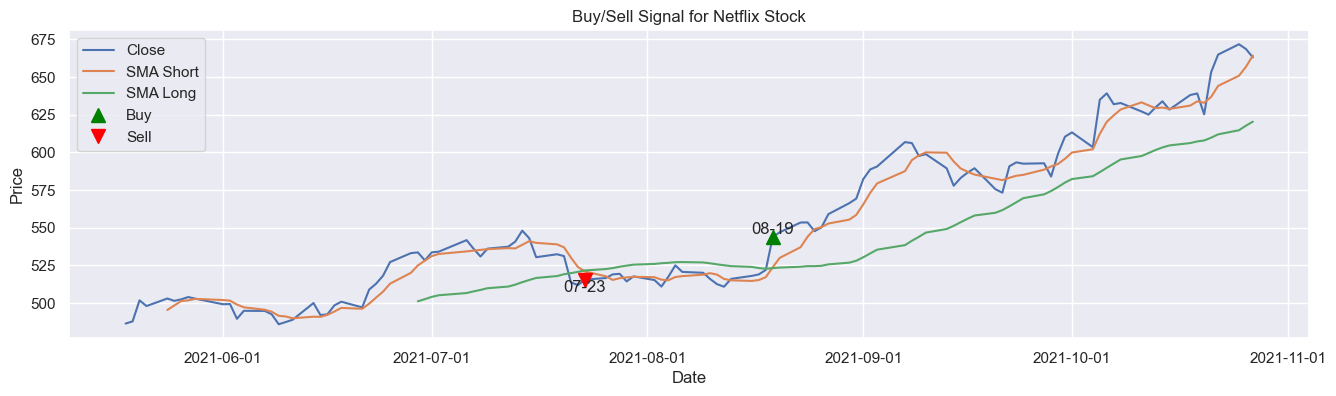

In [66]:
# Plot the Close price
plt.figure(figsize=(16, 4))
plt.plot(df_sam2['Close'], label='Close')

# Plot the short MA and long MA
ma_short = ta.trend.SMAIndicator(close=df_sam2['Close'], window=int(paras_best['ma_short'])).sma_indicator()
plt.plot(ma_short, label='SMA Short')

ma_long = ta.trend.SMAIndicator(close=df_sam2['Close'], window=int(paras_best['ma_long'])).sma_indicator()
plt.plot(ma_long, label='SMA Long')

# Plot the buy and sell signals
buy_dates = df_sam2[df_sam2['position'] == 1].index
sell_dates = df_sam2[df_sam2['position'] == -1].index

plt.plot(buy_dates, df_sam2.loc[buy_dates, 'Close'], '^', markersize=10, color='green', label='Buy')
plt.plot(sell_dates, df_sam2.loc[sell_dates, 'Close'], 'v', markersize=10, color='red', label='Sell')

# Add text to the buy and sell signals
for date in buy_dates:
    plt.text(date, df_sam2.loc[date, 'Close'], date.strftime('%m-%d'), ha='center', va='bottom')

for date in sell_dates:
    plt.text(date, df_sam2.loc[date, 'Close'], date.strftime('%m-%d'), ha='center', va='top')

# Format the x-axis
plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Buy/Sell Signal for Netflix Stock")
plt.legend()
plt.show()
